# FITS images in python; image statistics and plots

This notebook provides examples of reading a FITS image into a numpy array, plotting a histogram of the measured count values, and determining basic statistics of the count distribution.

More information on handling FITS files in python can be found [here](http://docs.astropy.org/en/stable/io/fits/).

In [1]:
### for array operations
import numpy as np

### for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### for operations on FITS images
from astropy.io import fits

### statistics functions needed in this tutorial
from scipy import stats
from scipy.stats import norm

In [2]:
### "fits.open" opens the FITS file
hdulist = fits.open('00000026.BIAS.FIT')

In [3]:
### let's look at what's in it
### in this case, a single extention, i.e. it has index 0
hdulist.info()

Filename: 00000026.BIAS.FIT
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   (1024, 1024)   int16 (rescales to uint16)   


In [4]:
### an image 
header = hdulist[0].header

In [5]:
### let's look at the header
header

SIMPLE  =                    T/CCDSOFT-SOFTWARE BISQUE 3                        
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
BSCALE  = +1.000000000000E+000                                                  
BZERO   = +3.276800000000E+004                                                  
BIAS    =                  100                                                  
FOCALLEN= +0.000000000000E+000                                                  
APTAREA = +0.000000000000E+000                                                  
APTDIA  = +0.000000000000E+000                                                  
OBSERVER= 'Anja                '                                                
DATE-OBS= '2017-09-01T15:58:

In [6]:
### ... and specifically the exposure time
header['EXPTIME']

0.0

In [7]:
### let's look at the image data now
imagedata = hdulist[0].data

In [8]:
### "imagedata" is now a numpy array
### to check it's dimensions, we can use:
imagedata.shape

(1024, 1024)

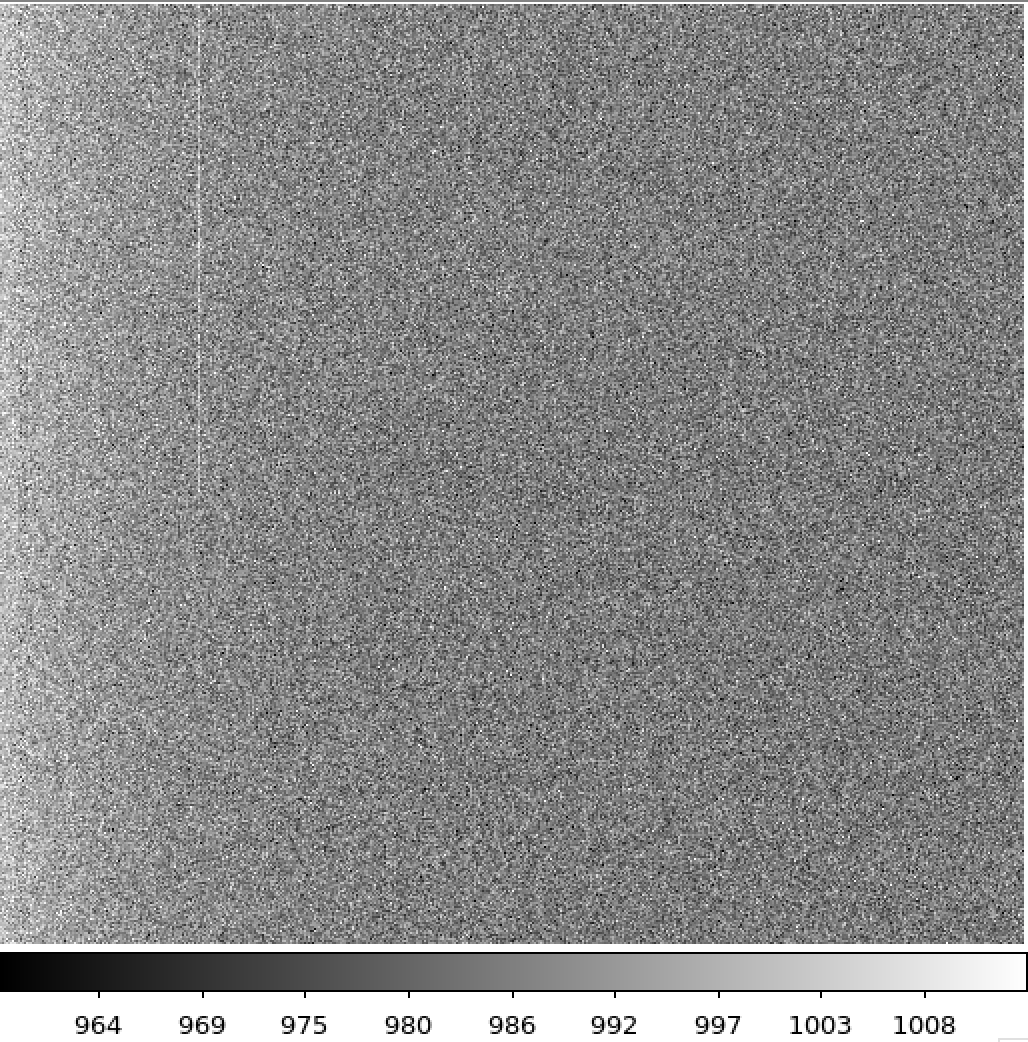

In [9]:
# To see the image, it is WAY easier to use ds9. The following is a 
# screenshot of this image as viewed from ds9, after clicking 'zscale'.

#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "bias.png", width = 400)

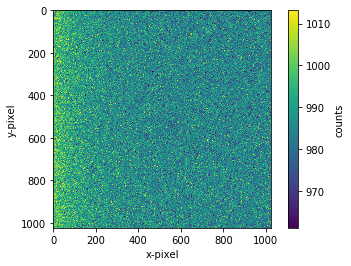

In [10]:
# you can use matplotlib to illustrate images

mean_ = np.mean(imagedata)
std = np.std(imagedata)

# make sure the range in the color scale is chosen wisely
# you can chose the range with vmin and vmax

#plt.imshow(np.log(imagedata))  
plt.imshow(imagedata, vmin=mean_-3*std, vmax=mean_+3*std) 
cbar = plt.colorbar()
cbar.set_label('counts')

plt.xlabel('x-pixel')
plt.ylabel('y-pixel')
plt.show()

In [11]:
### for plotting the histogram, calculating statistics, etc., it's useful to convert the 2d array into a 1d list:
countvalues = imagedata.flatten()

In [12]:
countvalues.shape

(1048576,)

In [13]:
### first, let's look at the maximum and minimum counts
print(np.max(countvalues))
print(np.min(countvalues))

4289
945


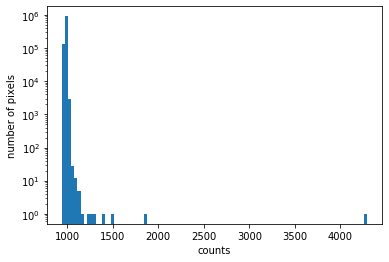

In [14]:
### plot a histogram, using a logarithmic y-axis
plt.hist(countvalues,bins=100)
plt.xlabel("counts")
plt.ylabel("number of pixels")
plt.yscale('log')

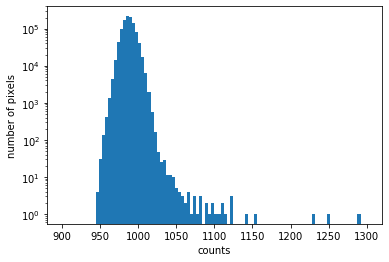

In [15]:
### let's re-plot, specifying a smaller range, and the number of bins:
plt.hist(countvalues,range=[900,1300], bins=100);
plt.yscale('log')
plt.xlabel("counts")
plt.ylabel("number of pixels")
plt.show()

In [16]:
### compute the mean, the median, the mode, and the standard deviation:
print(np.mean(countvalues), "mean")
print(stats.mode(countvalues)[0][0], "mode")
print(np.median(countvalues), "median")
print(np.std(countvalues), "std")

987.217583656311 mean
986 mode
987.0 median
8.642214562227608 std


In [17]:
### repeat the same, but clip "outliers":

clippedvalues = countvalues[countvalues<1050]

print(np.mean(clippedvalues), "mean")
print(stats.mode(clippedvalues)[0][0], "mode")
print(np.median(clippedvalues), "median")
print(np.std(clippedvalues), "std")

987.2084573560534 mean
986 mode
987.0 median
7.909362888986573 std


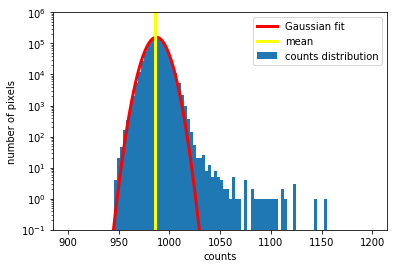

In [24]:
### overplot a normal distribution, as specified by the mean and standard deviation

cmin=900
cmax=1200
nbins=100
normalization=(cmax-cmin)/nbins*len(countvalues[(countvalues>=cmin) & (countvalues<=cmax)])

clipmin=cmin
clipmax=1100
clippedvalues = countvalues[(countvalues>=clipmin) & (countvalues<=clipmax)]

mu=np.mean(clippedvalues)
sig=np.std(clippedvalues)
mode=stats.mode(clippedvalues)[0][0]

xarray=np.linspace(cmin,cmax,nbins*10)
yarray=normalization*norm.pdf(xarray,loc=mu, scale=sig)

plt.hist(countvalues,range=[cmin,cmax], bins=nbins, label="counts distribution");
plt.yscale('log')
plt.ylim([0.1,1e6])
plt.plot(xarray,yarray,color="red",linewidth=3.0, label="Gaussian fit")
plt.axvline(x=mode,linewidth=3.0,color="yellow", label="mean")
plt.xlabel("counts")
plt.ylabel("number of pixels")
plt.legend()
plt.show()

### Operations on multiple files

In [19]:
### open a second file file
hdu2 = fits.open('00000025.BIAS.FIT')

### read image data into numpy array
imagedata2 = hdu2[0].data

In [20]:
### "simple" arithmetic operations such as addition etc. can be done straightforwardly such as
sum = imagedata + imagedata2

### for operations such as taking the mean, or median, of a list of array, 
### we first need to create an array out of all the images
### this can be done like this:
allimages=[imagedata2, imagedata]
### take the average of the two arrays
avg = np.mean(allimages, axis=0)

In [21]:
### the result is another numpy array with the same shape:
avg.shape

(1024, 1024)

### write a new fits file

More details of saving your data as a new fits file can be found [here](https://docs.astropy.org/en/stable/io/fits/#creating-a-new-image-file).

In [22]:
### write "avg" into a new fits file

# before we write the file, we make sure it does not exist, and if it does, we delete it (DANGEROUS!)
import os
try:
    os.remove('avg.fits')
except OSError:
    pass

newhdu = fits.PrimaryHDU(data=avg)
newhdu.writeto('avg.fits')

## make a color image in python

when you have images in different color filters, there are several ways of making color (rgb) images. A popular and convenient way is to use the make_lupton_rgb function of astropy

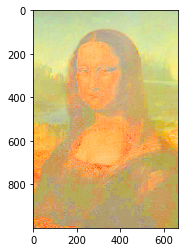

In [23]:
# load the image and convert into
# numpy array

from PIL import Image
 
img = Image.open("test_image.jpeg")
image_array = np.asarray(img)


image_r = np.array(image_array[:, :, 0], dtype=float)
image_g = np.array(image_array[:, :, 1], dtype=float)
image_b = np.array(image_array[:, :, 2], dtype=float)


from astropy.visualization import make_lupton_rgb

image_rgb = make_lupton_rgb(image_r, image_g, image_b)

plt.imshow(image_rgb)
plt.show()